In [27]:
import numpy as np
import torch
import pandas as pd
import torchaudio.transforms as T
import torchaudio.functional as F
import os
import torchaudio

In [28]:
import torchaudio

os.makedirs('/kaggle/working/data')

dataset = torchaudio.datasets.LIBRISPEECH(
    root="./data",         
    url="train-clean-100",
    download=True
)

FileExistsError: [Errno 17] File exists: '/kaggle/working/data'

In [13]:
dataset

In [14]:
waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id = dataset[1]

print("Waveform shape:", waveform.shape)
print("Sample rate:", sample_rate)
print("Transcript:", transcript)

Waveform shape: torch.Size([1, 255120])
Sample rate: 16000
Transcript: THAT HAD ITS SOURCE AWAY BACK IN THE WOODS OF THE OLD CUTHBERT PLACE IT WAS REPUTED TO BE AN INTRICATE HEADLONG BROOK IN ITS EARLIER COURSE THROUGH THOSE WOODS WITH DARK SECRETS OF POOL AND CASCADE BUT BY THE TIME IT REACHED LYNDE'S HOLLOW IT WAS A QUIET WELL CONDUCTED LITTLE STREAM


In [46]:
valid_data = []
for waveform, transcript,_,_,_,_ in dataset:
    if len(waveform[0]) >= len(transcript):  # rough heuristic
        valid_data.append((waveform, transcript))

TypeError: expected a sequence of integers or a single integer, got 'tensor([-0.0065, -0.0055, -0.0062,  ...,  0.0033,  0.0005, -0.0095])'

In [15]:
import string

# Spectrogram transform
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=16000,
    n_fft=400,
    hop_length=160,
    n_mels=80
)

def extract_features(waveform):
    mel = mel_transform(waveform).clamp(min=1e-5).log()
    return mel.squeeze(0).transpose(0, 1)  # shape: [time_steps, features]

In [84]:
blank_token = '<blank>'
vocab = [blank_token] + list(" ") + list(string.ascii_lowercase)
char2idx = {c: i for i, c in enumerate(vocab)}
idx2char = {i: c for c, i in char2idx.items()}
blank_idx = char2idx[blank_token]  # = 0

def text_to_indices(text):
    return [char2idx[c] for c in text.lower() if c in char2idx]

In [16]:
class ASRDataset(torch.utils.data.Dataset):
    def __init__(self, torchaudio_dataset):
        self.data = torchaudio_dataset

    def __getitem__(self, idx):
        waveform, sr, transcript, *_ = self.data[idx]
        if sr != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
            waveform = resampler(waveform)
        
        features = extract_features(waveform)
        targets = torch.tensor(text_to_indices(transcript), dtype=torch.long)
        return features, targets

    def __len__(self):
        return len(self.data)

In [47]:
def collate_fn(batch):
    inputs, targets = zip(*batch)

    input_lengths = torch.tensor([x.shape[0] for x in inputs])
    target_lengths = torch.tensor([y.shape[0] for y in targets])

    # Pad inputs
    padded_inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True)
    padded_targets = torch.cat(targets)  # Targets are concatenated for CTC loss

    return padded_inputs, padded_targets, input_lengths, target_lengths

In [48]:
asr_dataset = ASRDataset(dataset)

data_loader = torch.utils.data.DataLoader(
    asr_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn
)

Inputs shape: torch.Size([8, 1538, 80])
Targets shape: torch.Size([1531])
Input lengths: tensor([1450, 1538, 1433,  949, 1371, 1313, 1292, 1436])
Target lengths: tensor([279, 194, 203, 133, 172, 137, 189, 224])
Decoded target 0: and the sound of the neighboring cascade deepened with the night kwairyo felt thirsty as he listened to the noise of the water and remembering the bamboo aqueduct at the rear of the house he thought that he could go there and get a drink without disturbing the sleeping household


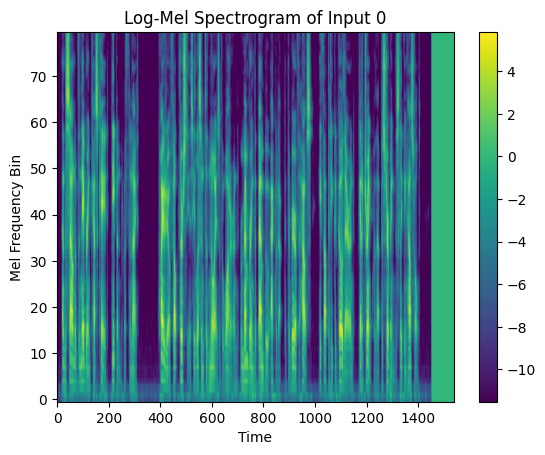

In [49]:
batch = next(iter(data_loader))

inputs, targets, input_lengths, target_lengths = batch
print(f"Inputs shape: {inputs.shape}")               # e.g., [8, max_time, 80]
print(f"Targets shape: {targets.shape}")             # e.g., [total_target_length]
print(f"Input lengths: {input_lengths}")             # e.g., [123, 115, ...]
print(f"Target lengths: {target_lengths}")           # e.g., [32, 29, ...]

# Check actual decoded characters
idx2char = {i: c for c, i in char2idx.items()}

# Print first transcript
target_0 = targets[:target_lengths[0]].tolist()
print("Decoded target 0:", ''.join([idx2char[i] for i in target_0]))

# Optional: Visualize spectrogram
import matplotlib.pyplot as plt
plt.imshow(inputs[0].cpu().T, aspect='auto', origin='lower')
plt.title("Log-Mel Spectrogram of Input 0")
plt.xlabel("Time")
plt.ylabel("Mel Frequency Bin")
plt.colorbar()
plt.show()

In [50]:
import torch.nn as nn

class ASRModel(nn.Module):
    def __init__(self, input_dim=80, hidden_dim=256, output_dim=len(char2idx), num_layers=3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(hidden_dim * 2, output_dim)  # bidirectional

    def forward(self, x):
        outputs, _ = self.lstm(x)           # x: [B, T, F] → outputs: [B, T, 2*H]
        logits = self.classifier(outputs)   # [B, T, vocab_size]
        return logits.log_softmax(dim=-1)   # CTC expects log-probabilities

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ASRModel().to(device)

criterion = nn.CTCLoss(blank=char2idx[' '], zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [52]:
device

device(type='cuda')

In [112]:
from tqdm import tqdm

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for inputs, targets, input_lengths, target_lengths in tqdm(small_data_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        # lengths on CPU as longs
        input_lengths = input_lengths.cpu().long()
        target_lengths = target_lengths.cpu().long()
    
        optimizer.zero_grad()
        logits = model(inputs)  # [B, T, vocab]
        log_probs = torch.nn.functional.log_softmax(logits, dim=-1)  # apply log_softmax
        log_probs = log_probs.permute(1, 0, 2)  # [T, B, vocab]
    
        loss = criterion(log_probs, targets, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
    
        total_loss += loss.item() * inputs.size(0)

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(small_data_loader.dataset):.4f}")
    print("Min input length:", input_lengths.min().item())
    print("Max target length:", target_lengths.max().item())


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


Epoch 1, Loss: 0.8549
Min input length: 979
Max target length: 268


100%|██████████| 313/313 [02:20<00:00,  2.22it/s]


Epoch 2, Loss: 0.8246
Min input length: 211
Max target length: 234


100%|██████████| 313/313 [02:20<00:00,  2.22it/s]


Epoch 3, Loss: 0.7963
Min input length: 410
Max target length: 293


100%|██████████| 313/313 [02:21<00:00,  2.22it/s]


Epoch 4, Loss: 0.7713
Min input length: 565
Max target length: 277


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


Epoch 5, Loss: 0.7467
Min input length: 428
Max target length: 211


100%|██████████| 313/313 [02:20<00:00,  2.22it/s]


Epoch 6, Loss: 0.7206
Min input length: 919
Max target length: 255


100%|██████████| 313/313 [02:20<00:00,  2.22it/s]


Epoch 7, Loss: 0.6931
Min input length: 1380
Max target length: 245


100%|██████████| 313/313 [02:20<00:00,  2.22it/s]


Epoch 8, Loss: 0.6742
Min input length: 391
Max target length: 272


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


Epoch 9, Loss: 0.6519
Min input length: 240
Max target length: 279


100%|██████████| 313/313 [02:20<00:00,  2.22it/s]


Epoch 10, Loss: 0.6295
Min input length: 250
Max target length: 267


100%|██████████| 313/313 [02:20<00:00,  2.22it/s]


Epoch 11, Loss: 0.6085
Min input length: 299
Max target length: 278


100%|██████████| 313/313 [02:21<00:00,  2.22it/s]


Epoch 12, Loss: 0.5884
Min input length: 579
Max target length: 261


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


Epoch 13, Loss: 0.5703
Min input length: 446
Max target length: 258


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


Epoch 14, Loss: 0.5505
Min input length: 740
Max target length: 301


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


Epoch 15, Loss: 0.5329
Min input length: 1114
Max target length: 266


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


Epoch 16, Loss: 0.5137
Min input length: 823
Max target length: 300


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


Epoch 17, Loss: 0.4958
Min input length: 570
Max target length: 277


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


Epoch 18, Loss: 0.4819
Min input length: 605
Max target length: 243


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


Epoch 19, Loss: 0.4641
Min input length: 821
Max target length: 254


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


Epoch 20, Loss: 0.4481
Min input length: 528
Max target length: 265


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


Epoch 21, Loss: 0.4329
Min input length: 938
Max target length: 246


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


Epoch 22, Loss: 0.4165
Min input length: 283
Max target length: 266


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


Epoch 23, Loss: 0.4038
Min input length: 404
Max target length: 288


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


Epoch 24, Loss: 0.3887
Min input length: 1109
Max target length: 258


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


Epoch 25, Loss: 0.3763
Min input length: 218
Max target length: 229


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


Epoch 26, Loss: 0.3617
Min input length: 499
Max target length: 240


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


Epoch 27, Loss: 0.3494
Min input length: 1129
Max target length: 220


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


Epoch 28, Loss: 0.3370
Min input length: 727
Max target length: 290


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


Epoch 29, Loss: 0.3228
Min input length: 1074
Max target length: 247


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]

Epoch 30, Loss: 0.3115
Min input length: 486
Max target length: 239


In [24]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 46.3 MB/s eta 0:00:00a 0:00:01


In [1]:
subset_size = 5000 
small_dataset = torch.utils.data.Subset(asr_dataset, range(subset_size))

small_data_loader = torch.utils.data.DataLoader(
    small_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn
)

NameError: name 'torch' is not defined

In [103]:
from jiwer import wer, cer

model.eval()

def decode_targets(targets, target_lengths, idx2char):
    results = []
    index = 0
    for length in target_lengths:
        seq = targets[index:index + length].cpu().numpy()
        results.append(''.join([idx2char[i] for i in seq]))
        index += length
    return results

import torch
import numpy as np

def beam_search_decode(logits, blank_idx, beam_width=8):
    batch_size, max_time, vocab_size = logits.shape
    results = []

    # Work batch element by element (can be optimized for batching)
    for b in range(batch_size):
        log_prob = torch.nn.functional.log_softmax(logits[b], dim=-1).cpu().numpy()  # [T, vocab]

        # Each beam is (sequence, score)
        beams = [([], 0.0)]  # start with empty sequence and zero score

        for t in range(max_time):
            new_beams = []
            for seq, score in beams:
                for c in range(vocab_size):
                    p = log_prob[t, c]
                    new_seq = seq.copy()
                    # CTC blank or repeated character handling:
                    if c != blank_idx and (len(seq) == 0 or c != seq[-1]):
                        new_seq.append(c)
                    # Update score (add log prob)
                    new_score = score + p
                    new_beams.append((new_seq, new_score))
            # Keep top beam_width sequences
            new_beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]
            beams = new_beams

        # Take best beam
        best_seq, best_score = beams[0]

        # Convert indices to chars
        # Also remove consecutive duplicates and blanks (already handled above, but just in case)
        output = []
        prev = -1
        for i in best_seq:
            if i != prev and i != blank_idx:
                output.append(idx2char[i])
            prev = i
        results.append(''.join(output))
    return results


with torch.no_grad():
    for inputs, targets, input_lengths, target_lengths in data_loader:
        inputs = inputs.to(device)

        logits = model(inputs)                            # [B, T, vocab]
        print(logits)
        log_probs = torch.nn.functional.log_softmax(logits, dim=-1)  # still optional if already softmaxed

        predictions = beam_search_decode(logits, blank_idx)
        references = decode_targets(targets, target_lengths, idx2char)

        for pred, ref in zip(predictions, references):
            print("Prediction: ", pred)
            print("Ground truth:", ref)
            print("WER:", wer(ref, pred))
            print("CER:", cer(ref, pred))
            print("-" * 40)

        break  # first batch only


tensor([[[-6.7009e-04, -8.2451e+00, -9.9007e+00,  ..., -1.4948e+01,
          -1.3768e+01, -1.3597e+01],
         [-1.9489e-04, -9.4248e+00, -1.0500e+01,  ..., -1.6798e+01,
          -1.5321e+01, -1.5121e+01],
         [-6.8424e-05, -1.0425e+01, -1.1089e+01,  ..., -1.8005e+01,
          -1.6564e+01, -1.6392e+01],
         ...,
         [-2.4492e+00, -3.1384e+00, -3.0975e+00,  ..., -3.4828e+00,
          -3.4245e+00, -3.4716e+00],
         [-2.6178e+00, -3.2043e+00, -3.1525e+00,  ..., -3.4573e+00,
          -3.4454e+00, -3.4735e+00],
         [-2.8008e+00, -3.2578e+00, -3.1979e+00,  ..., -3.4408e+00,
          -3.4723e+00, -3.4793e+00]],

        [[-4.5635e-04, -7.9051e+00, -1.0663e+01,  ..., -1.6557e+01,
          -1.3301e+01, -1.4896e+01],
         [-7.6291e-05, -9.6886e+00, -1.1928e+01,  ..., -1.8976e+01,
          -1.5794e+01, -1.7583e+01],
         [-1.3590e-05, -1.1452e+01, -1.3108e+01,  ..., -2.0833e+01,
          -1.7776e+01, -1.9817e+01],
         ...,
         [-6.6757e-06, -1

In [94]:
!pip install https://github.com/kpu/kenlm/archive/master.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.6/553.6 kB 10.9 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for kenlm: filename=kenlm-0.2.0-cp311-cp311-linux_x86_64.whl size=3185091 sha256=3f07b9d08d263df6292fe2b640bdf72d31152a0b37b7de950c35cd014c544db5
  Stored in directory: /tmp/pip-ephem-wheel-cache-m6ev5vqk/wheels/4e/ca/6a/e5da175b1396483f6f410cdb4cfe8bc8fa5e12088e91d60413
Successfully built kenlm


In [97]:
import kenlm

lm = kenlm.Model('/kaggle/input/lm-for-asr/3-gram.pruned.3e-7.arpa')

Loading the LM will be faster if you build a binary file.
Reading /kaggle/input/lm-for-asr/3-gram.pruned.3e-7.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************


In [110]:
from jiwer import wer, cer

model.eval()

def decode_targets(targets, target_lengths, idx2char):
    results = []
    index = 0
    for length in target_lengths:
        seq = targets[index:index + length].cpu().numpy()
        results.append(''.join([idx2char[i] for i in seq]))
        index += length
    return results

def beam_search_decode_with_lm(logits, blank_idx, idx2char, beam_width=8):
    batch_size, max_time, vocab_size = logits.shape
    results = []

    for b in range(batch_size):
        log_prob = torch.nn.functional.log_softmax(logits[b], dim=-1).cpu().numpy()  # [T, vocab]

        beams = [([], 0.0)]

        for t in range(max_time):
            new_beams = []
            for seq, score in beams:
                for c in range(vocab_size):
                    p = log_prob[t, c]
                    new_seq = seq.copy()
                    if c != blank_idx and (len(seq) == 0 or c != seq[-1]):
                        new_seq.append(c)
                    new_score = score + p
                    new_beams.append((new_seq, new_score))
            new_beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width * 2]

            # Re-rank using language model
            lm_scored = []
            for seq, score in new_beams:
                chars = [idx2char[i] for i in seq if i != blank_idx]
                text = ''.join(chars)
                text = text.replace("  ", " ").strip()
                lm_score = lm.score(text, bos=True, eos=True)
                combined_score = 0.1 * score + 1.5 * lm_score  # tune LM weight as needed
                lm_scored.append((seq, combined_score))

            beams = sorted(lm_scored, key=lambda x: x[1], reverse=True)[:beam_width]

        best_seq, _ = beams[0]
        output = []
        prev = -1
        for i in best_seq:
            if i != prev and i != blank_idx:
                output.append(idx2char[i])
            prev = i
        results.append(''.join(output))

    return results

with torch.no_grad():
    for inputs, targets, input_lengths, target_lengths in data_loader:
        inputs = inputs.to(device)

        logits = model(inputs)  # [B, T, vocab]
        predictions = beam_search_decode_with_lm(logits, blank_idx, idx2char)
        references = decode_targets(targets, target_lengths, idx2char)

        for pred, ref in zip(predictions, references):
            print("Prediction: ", pred)
            print("Ground truth:", ref)
            print("WER:", wer(ref, pred))
            print("CER:", cer(ref, pred))
            print("-" * 40)

        break  # first batch only

Prediction:  but afer h ithig ad as out te pels o fedworit and ofthedoid ano the hos but in mi same ers nd he ae ener histerane e pepls iys perteg uch o ord et ed the ton
Ground truth: but after that i think it was about the twelfth of february another died in another house but in the same parish and in the same manner this turned the peoples eyes pretty much towards that end of the town
WER: 0.875
CER: 0.4097560975609756
----------------------------------------
Prediction:  which is the prnsuple esupticl ith eblid and e trumk of e tre at oarpd of which e other vrngs in the boty oar braghes and the or erialthing en at da os int a rpit ley o noenidt
Ground truth: which is the principal receptacle of the blood and the trunk of the tree as it were of which all the other veins in the body are branches and the arterial vein vena arteriosa inappropriately so denominated
WER: 0.8108108108108109
CER: 0.37073170731707317
----------------------------------------
Prediction:  nous put me o he ipe